# Model Comparisons

1. This notebook aims to compare different classification model and find the best performing ones
2. Although, logistic regression has demonstrated a very good performance, we would like to see its performance vs XGBoost and Decision Tree Classsifier
    - XGBoost had dominated many Kaggle competitions and achieved SOTA results on a variety of datasets 
    - We will also consider model such as naive bayes, support vector machine and linear discriminant analysis. 
3. We will then evaluate the model based on their accuracy score across each cross validation fold. Other scores will also be used as comparison metrics

https://arxiv.org/pdf/1603.02754.pdf

In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import xgboost
from xgboost import XGBClassifier


In [2]:
# load data
data = pd.read_csv('data/predictor.csv')
data.head(2)

,distance,city,state,zip,flood_risk
0,0.000000,Kuala Lumpur,Kuala Lumpur,50050,1
1,1267.271558,Johor Bahru,Johor,80400,0


In [3]:
# train test split
X = data[['distance','state']]

y = data['flood_risk']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((3343, 2), (836, 2), (3343,), (836,))

In [4]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # ori: spare = False

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [5]:
# one hot encoding will rename column as number, we will rename back to original name
OH_X_train.columns = ['distance', 'Kuala Lumpur', 'Johor', 'Selangor', 'Penang', 'Perak', 'Sarawak', 'Sabah',
 'Pahang', 'Negeri Sembilan', 'Terengganu', 'Melaka', 'Kedah', 'Kelantan',
 'Labuan']

OH_X_train.head()

,distance,Kuala Lumpur,Johor,Selangor,Penang,Perak,Sarawak,Sabah,Pahang,Negeri Sembilan,Terengganu,Melaka,Kedah,Kelantan,Labuan
1515,406.429619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2433,1277.058713,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2558,779.839293,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3617,314.436809,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1742,573.489954,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
OH_X_valid.columns = ['distance', 'Kuala Lumpur', 'Johor', 'Selangor', 'Penang', 'Perak', 'Sarawak', 'Sabah',
 'Pahang', 'Negeri Sembilan', 'Terengganu', 'Melaka', 'Kedah', 'Kelantan',
 'Labuan']

OH_X_valid.head()

,distance,Kuala Lumpur,Johor,Selangor,Penang,Perak,Sarawak,Sabah,Pahang,Negeri Sembilan,Terengganu,Melaka,Kedah,Kelantan,Labuan
3004,217.281156,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,244.799012,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2717,254.861137,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3016,36.470273,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2432,1271.408095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
# prepare models
models = []
models.append(('LR', LogisticRegression(solver = 'liblinear', random_state=0)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('XGB', XGBClassifier()))

In [8]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, OH_X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.992821 (0.005710)
LDA: 0.871383 (0.026826)
CART: 1.000000 (0.000000)
NB: 0.819942 (0.022908)
SVM: 0.997905 (0.002338)
XGB: 1.000000 (0.000000)


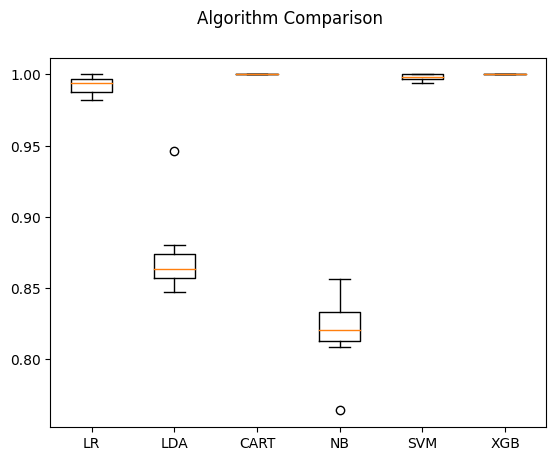

In [9]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [11]:
algorithms = [
     #GLM
    # linear_model.LogisticRegressionCV(solver = 'liblinear'),
    # linear_model.PassiveAggressiveClassifier(),
    
    #Ensemble Methods
    # ensemble.AdaBoostClassifier(),
    #ensemble.GradientBoostingClassifier(),
    #ensemble.RandomForestClassifier(),

    #Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(),
    
    #SVM
    #svm.SVC(probability=True),
    #svm.NuSVC(probability=True),
    #svm.LinearSVC(),
    
    #Trees    
    #tree.DecisionTreeClassifier(),
  
    #Navies Bayes
    #naive_bayes.BernoulliNB(),
    #naive_bayes.GaussianNB(),
    linear_model.LogisticRegression(solver = 'liblinear'),
    xgboost.XGBClassifier()
    
]

In [12]:
# performance comparison
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)
row_index = 0
for alg in algorithms:  
    
    predicted = alg.fit(OH_X_train, y_train).predict(OH_X_valid)
    fp, tp, th = roc_curve(y_valid, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA used'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(OH_X_train, y_train), 5)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(OH_X_valid, y_valid), 5)
    MLA_compare.loc[row_index, 'Precission'] = precision_score(y_valid, predicted)
    MLA_compare.loc[row_index, 'Recall'] = recall_score(y_valid, predicted)
    MLA_compare.loc[row_index, 'AUC'] = auc(fp, tp)

    row_index+=1
    
MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

,MLA used,Train Accuracy,Test Accuracy,Precission,Recall,AUC
1,XGBClassifier,1.00000,1.00000,1.000000,1.000000,1.000000
0,LogisticRegression,0.99282,0.98804,0.992095,0.969112,0.982823


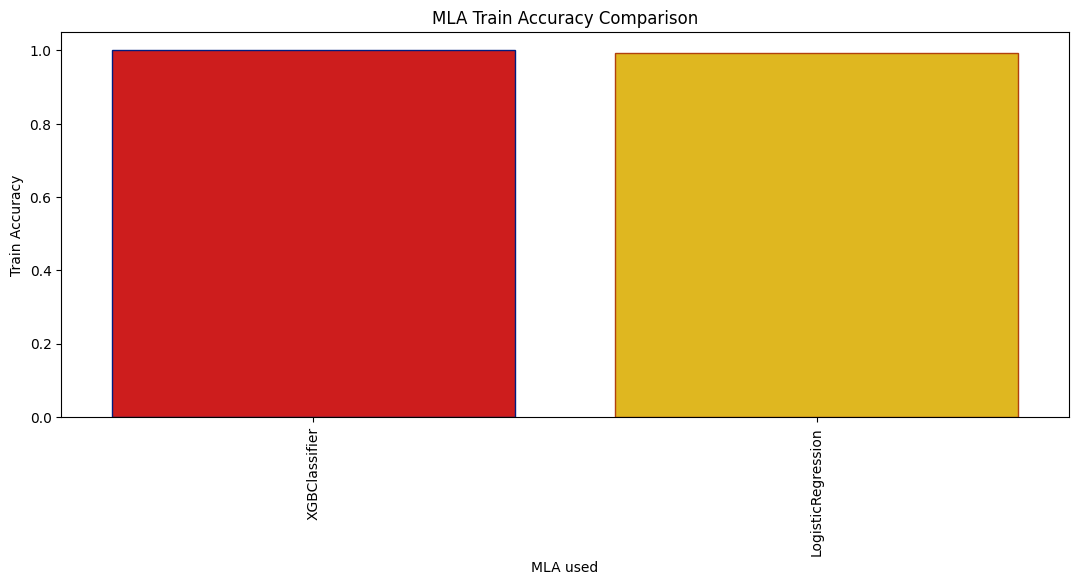

In [13]:
# Creating plot to show the train accuracy
plt.subplots(figsize=(13,5))
sns.barplot(x="MLA used", y="Train Accuracy",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MLA Train Accuracy Comparison')
plt.savefig("images/MLA_train_accuracy.png")

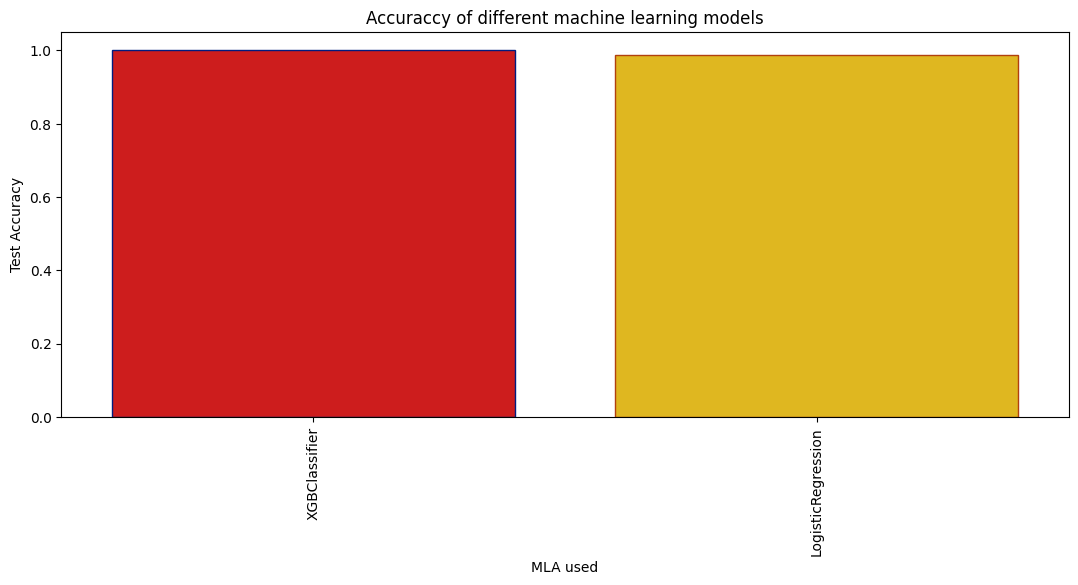

In [14]:
# Creating plot to show the test accuracy
plt.subplots(figsize=(13,5))
sns.barplot(x="MLA used", y="Test Accuracy",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Accuraccy of different machine learning models')
plt.savefig('images/MLA_compare.png')

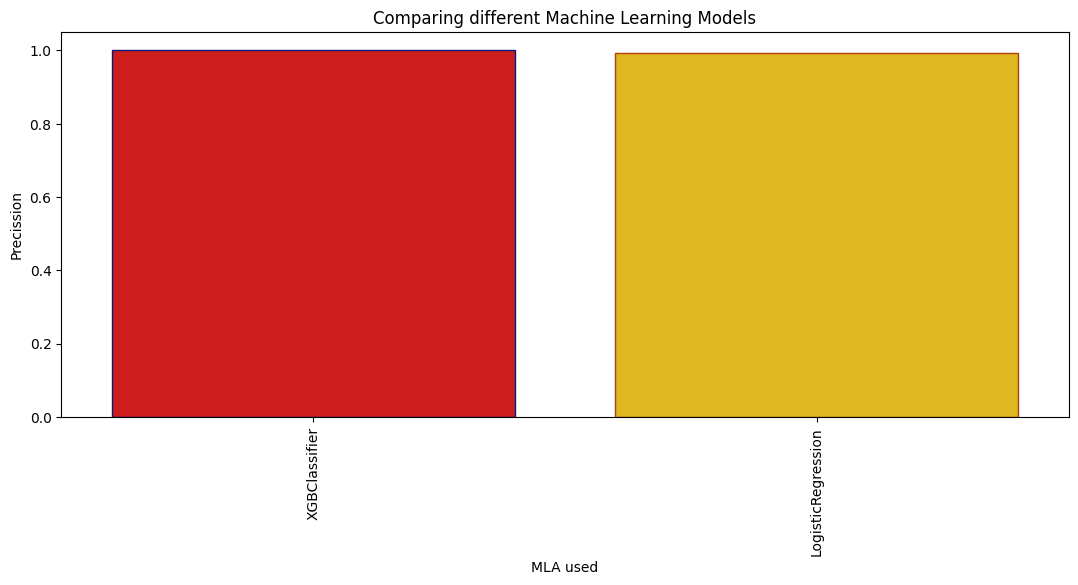

In [15]:
# Creating plots to compare precission of the MLAs
plt.subplots(figsize=(13,5))
sns.barplot(x="MLA used", y="Precission",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Comparing different Machine Learning Models')
plt.savefig('images/MLA_compare.png')

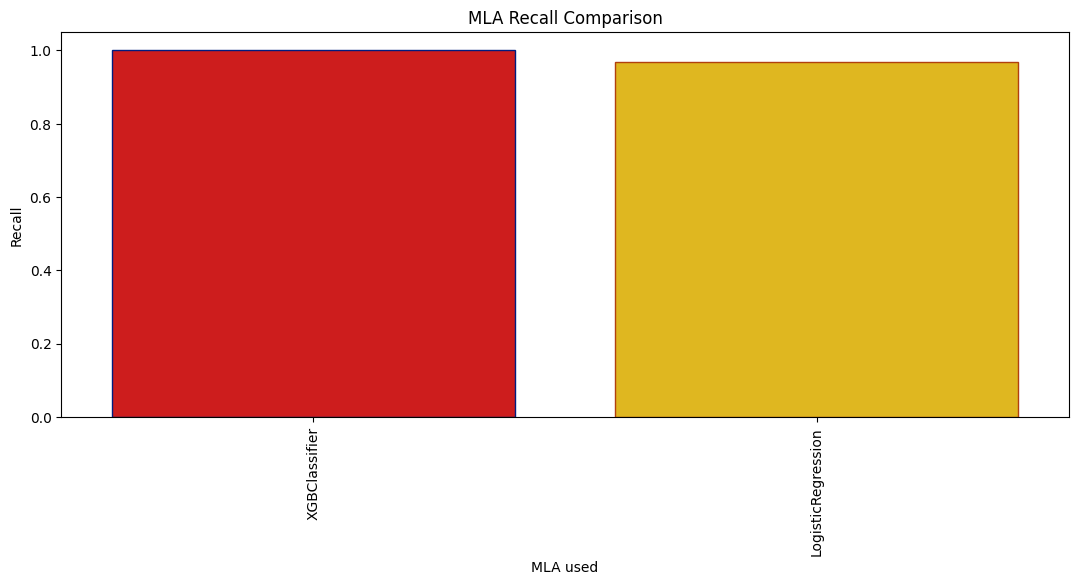

In [16]:
# Creating plots for MLA recall comparison
plt.subplots(figsize=(13,5))
sns.barplot(x="MLA used", y="Recall",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MLA Recall Comparison')
plt.savefig('images/MLA Recall Comparison.png')

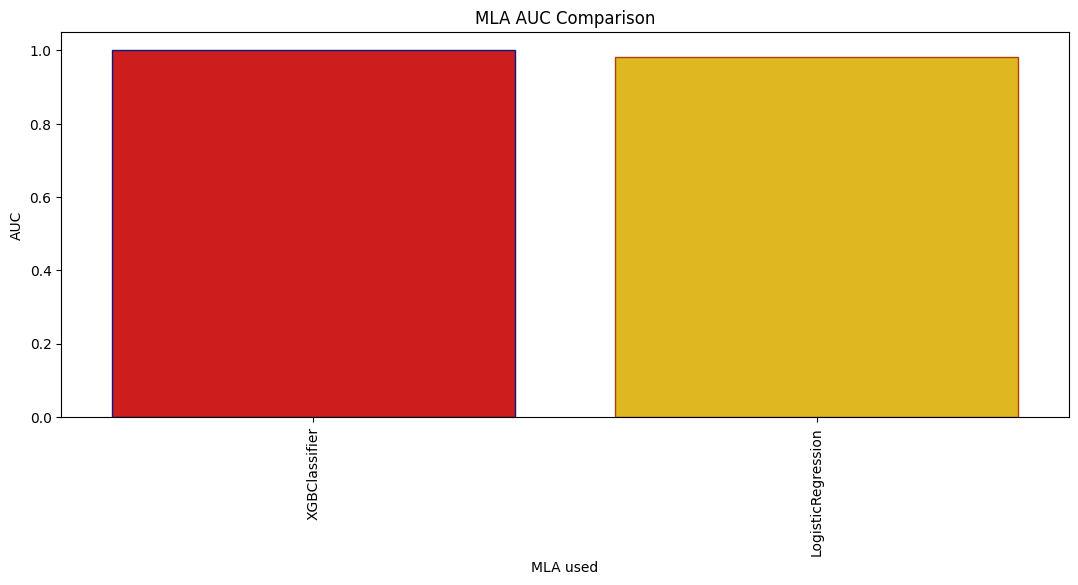

In [17]:
# Creating plot for MLA AUC comparison
plt.subplots(figsize=(13,5))
sns.barplot(x="MLA used", y="AUC",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MLA AUC Comparison')
plt.savefig('images/MLA_AUC_Comparison.png')

Text(0.5, 0, 'False Positive Rate')

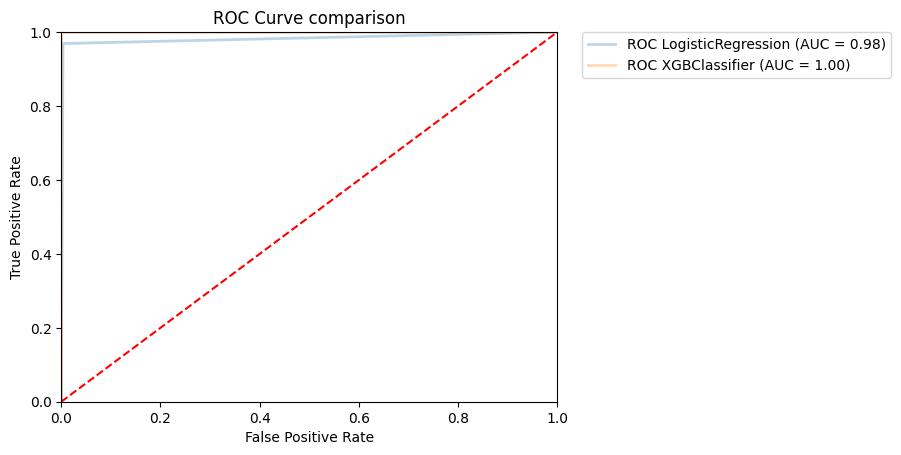

In [18]:
# Creating plot to show the ROC for all MLA
index = 1
for alg in algorithms:
    
    
    predicted = alg.fit(OH_X_train, y_train).predict(OH_X_valid)
    fp, tp, th = roc_curve(y_valid, predicted)
    roc_auc_mla = auc(fp, tp)
    MLA_name = alg.__class__.__name__
    plt.plot(fp, tp, lw=2, alpha=0.3, label='ROC %s (AUC = %0.2f)'  % (MLA_name, roc_auc_mla))
   
    index+=1

plt.title('ROC Curve comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    

# Conclusion
1. From the outcome, although we have shown logistic regression to be a very good classifier, there are several classifiers able to outperform it by achieving 100% accuracy
2. Limitation of this study
    - The flood data itself is not completed due to geocoding and a lot of flood data points are lost
    - The random location generated are not evenly distributed with a high concentration of location point in some states but not the other, this can also due to data lost as most of the location are determined by the success of the Geo locator's output
    - The distance is calculated by assuming that there is flood risk within 500 m radius of any historical flood location, this could not be very reliable as based on all the distance collected the mean is about 1000 m and 25 % percentile is only 413 m